## hey 

In [2]:
import pandas as pd

In [3]:
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)

In [5]:
df = pd.read_csv('../data/benin-malanville.csv')

In [6]:
df.head()

,Timestamp,GHI,...,TModB,Comments
0,2021-08-09 00:01,-1.2,...,26.2,NaN
1,2021-08-09 00:02,-1.1,...,26.2,NaN
2,2021-08-09 00:03,-1.1,...,26.2,NaN
3,2021-08-09 00:04,-1.1,...,26.3,NaN
4,2021-08-09 00:05,-1.0,...,26.3,NaN


In [7]:
df.shape

(525600, 19)

In [8]:
df.columns

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

In [10]:
df['Cleaning'].unique()

array([0, 1])

In [11]:
df.describe().T

,count,mean,...,75%,max
GHI,525600.0,240.559452,...,483.4,1413.0
DNI,525600.0,167.187516,...,314.2,952.3
...,...,...,...,...,...
TModB,525600.0,32.471736,...,41.5,72.5
Comments,0.0,NaN,...,NaN,NaN


In [12]:
df.isna().sum()

Timestamp         0
GHI               0
              ...  
TModB             0
Comments     525600
Length: 19, dtype: int64

In [13]:
missing_percent = df.isna().mean() * 100
missing_percent[missing_percent > 5]

Comments    100.0
dtype: float64

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df = df.drop_duplicates()

In [16]:
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

In [18]:
from scipy import stats

In [21]:
print(cols_to_check)

['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']


In [23]:
import numpy as np


In [24]:
z_scores = np.abs(stats.zscore(df[cols_to_check], nan_policy='omit'))

In [25]:
outliers = (z_scores > 3)

In [26]:
outliers.sum(axis=0)

array([  89,    0, 3738,   27,   63, 3109, 3500])

In [27]:
df_clean = df[(z_scores < 3).all(axis=1)]

In [28]:
df = df.fillna(df.median(numeric_only=True))

In [29]:
df['GHI'] = df['GHI'].fillna(df['GHI'].median())


In [31]:
df.to_csv('../data/benin_clean.csv', index=False)


In [90]:
# Compatibility shim: some Sweetviz versions expect numpy.VisibleDeprecationWarning
# which may be missing in newer NumPy releases. This sets a fallback before import.
import numpy as np
if not hasattr(np, 'VisibleDeprecationWarning'):
    # use built-in DeprecationWarning as a compatible substitute
    np.VisibleDeprecationWarning = DeprecationWarning
import sweetviz as sv

In [91]:
report = sv.analyze(df)
report.show_html('sweetviz_report.html')

Feature: GHI                                 |█         | [ 10%]   1:57:45 -> (17:39:45 left)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:04 -> (00:00 left)



Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [40]:
import os
import pandas as pd
import numpy as np
from scipy import stats

In [24]:
RAW_PATH  = '../data/benin-malanville.csv'      # input
CLEAN_DIR = 'data'
CLEAN_FN  = 'benin_clean.csv'         # output
OUTLIER_METHOD = 'zscore'             # 'zscore' or 'iqr'
ZSCORE_THRESH = 3.0
IQR_FACTOR = 1.5
NUMERIC_FILL = 'median'

In [42]:
os.makedirs(CLEAN_DIR, exist_ok=True)

In [43]:
def load_data(path):
    # parse timestamp column if present
    df = pd.read_csv(path, parse_dates=['Timestamp'], infer_datetime_format=True)
    return df

In [45]:
def basic_profile(df):
    print("shape:", df.shape)
    print("\ninfo:")
    print(df.info())
    print("\ndescribe:")
    print(df.describe().T)
    print("\nmissing % per col:")
    print((df.isna().mean()*100).round(2).sort_values(ascending=False))



In [46]:
def fix_column_names(df):
    # strip whitespace and standardize names
    df.columns = [c.strip() for c in df.columns]
    return df

In [47]:
def convert_types(df):
    # Ensure numeric columns are numeric (coerce invalid -> NaN)
    numeric_cols = df.select_dtypes(include=['int','float']).columns.tolist()
    # also try to coerce expected numeric-like columns that might be object
    maybe_numeric = ['GHI','DNI','DHI','ModA','ModB','Tamb','RH','WS','WSgust','BP','Precipitation','TModA','TModB']
    for col in maybe_numeric:
        if col in df.columns and df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [48]:
def drop_exact_duplicates(df):
    n_dup = df.duplicated().sum()
    if n_dup>0:
        df = df.drop_duplicates()
        print(f"dropped {n_dup} exact duplicate rows")
    return df

In [49]:
def handle_outliers(df, method='zscore'):
    cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
    cols = [c for c in cols if c in df.columns]
    if method=='zscore':
        # compute zscore skipping NaNs
        z = np.abs(stats.zscore(df[cols], nan_policy='omit'))
        # rows with any |z|> thresh are outliers
        mask_out = (z > ZSCORE_THRESH).any(axis=1)
        print("outlier rows (zscore) count:", int(mask_out.sum()))
        # Option: mark instead of drop
        df['_outlier_flag'] = False
        df.loc[mask_out, '_outlier_flag'] = True
        # To remove: df = df[~mask_out].copy()
    else:  # IQR
        mask_out = pd.Series(False, index=df.index)
        for c in cols:
            q1 = df[c].quantile(0.25)
            q3 = df[c].quantile(0.75)
            iqr = q3 - q1
            low = q1 - IQR_FACTOR * iqr
            high= q3 + IQR_FACTOR * iqr
            mask_out = mask_out | ( (df[c] < low) | (df[c] > high) )
        print("outlier rows (IQR) count:", int(mask_out.sum()))
        df['_outlier_flag'] = mask_out
    return df

In [50]:
def impute_missing(df, strategy='median'):
    # Numeric imputation
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # do not impute index or timestamp or flags
    num_cols = [c for c in num_cols if c not in ['Cleaning','_outlier_flag']]
    if strategy=='median':
        med = df[num_cols].median()
        df[num_cols] = df[num_cols].fillna(med)
    elif strategy=='mean':
        df[num_cols] = df[num_cols].fillna(df[num_cols].mean())
    else:
        df[num_cols] = df[num_cols].fillna(0)
    # For Cleaning flag (if exists), fill with 0 (no cleaning)
    if 'Cleaning' in df.columns:
        df['Cleaning'] = df['Cleaning'].fillna(0).astype(int)
    return df

In [51]:
def engineering(df):
    # add derived features useful for EDA
    if 'Timestamp' in df.columns:
        df['year']  = df['Timestamp'].dt.year
        df['month'] = df['Timestamp'].dt.month
        df['day']   = df['Timestamp'].dt.day
        df['hour']  = df['Timestamp'].dt.hour
    return df

In [52]:
def save_clean(df, out_dir, fname):
    outp = os.path.join(out_dir, fname)
    df.to_csv(outp, index=False)
    print("Saved cleaned file:", outp)


In [55]:
if __name__ == '__main__':
    df = load_data('../data/benin-malanville.csv')
    df = fix_column_names(df)
    basic_profile(df)
    df = convert_types(df)
    df = drop_exact_duplicates(df)
    df = handle_outliers(df, method=OUTLIER_METHOD)
    df = impute_missing(df, strategy=NUMERIC_FILL)
    df = engineering(df)
    save_clean(df, CLEAN_DIR, CLEAN_FN)

C:\Users\user\AppData\Local\Temp\ipykernel_26180\2444514070.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(path, parse_dates=['Timestamp'], infer_datetime_format=True)


shape: (525600, 19)

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non

In [57]:
import os, pandas as pd, numpy as np
from scipy import stats
os.makedirs('data', exist_ok=True)
df = pd.read_csv('../data/benin-malanville.csv', parse_dates=['Timestamp'], infer_datetime_format=True)
df.columns = [c.strip() for c in df.columns]
df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_26180\1332449765.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('../data/benin-malanville.csv', parse_dates=['Timestamp'], infer_datetime_format=True)


,Timestamp,GHI,...,TModB,Comments
0,2021-08-09 00:01:00,-1.2,...,26.2,NaN
1,2021-08-09 00:02:00,-1.1,...,26.2,NaN
2,2021-08-09 00:03:00,-1.1,...,26.2,NaN
3,2021-08-09 00:04:00,-1.1,...,26.3,NaN
4,2021-08-09 00:05:00,-1.0,...,26.3,NaN


In [58]:
df.info()
(df.isna().mean()*100).sort_values(ascending=False).head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

Comments    100.0
GHI           0.0
            ...  
TModA         0.0
TModB         0.0
Length: 19, dtype: float64

In [59]:
# coerce selected columns
for c in ['GHI','DNI','DHI','ModA','ModB','Tamb','RH','WS','WSgust','BP']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
print("duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


duplicates: 0


In [60]:
cols = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust'] if c in df.columns]
z = np.abs(stats.zscore(df[cols], nan_policy='omit'))
df['_outlier_flag'] = False
df.loc[(z>3).any(axis=1), '_outlier_flag'] = True
df['_outlier_flag'].value_counts()


_outlier_flag
False    517860
True       7740
Name: count, dtype: int64

In [61]:
num_cols = df.select_dtypes(include=[np.number]).columns.drop('_outlier_flag', errors='ignore')
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
if 'Cleaning' in df.columns:
    df['Cleaning'] = df['Cleaning'].fillna(0).astype(int)
df['year']=df['Timestamp'].dt.year; df['month']=df['Timestamp'].dt.month; df['hour']=df['Timestamp'].dt.hour
df.to_csv('data/benin_clean.csv', index=False)
print("clean file saved")


clean file saved


In [ ]:
from bleach import clean


clean.isna().sum()


Timestamp    0
GHI          0
            ..
month        0
hour         0
Length: 23, dtype: int64

In [64]:
clean = clean.dropna()


In [65]:
clean = clean.dropna(axis=1)


In [66]:
assert clean.isna().sum().sum() == 0 or clean.isna().mean().max() < 0.05
print("✅ Data cleaned successfully! Shape:", clean.shape)


✅ Data cleaned successfully! Shape: (0, 23)


In [67]:


# Assuming your data is in a DataFrame named 'df'
num_rows = len(df)
# Or
num_rows = df.shape[0]

print(f"Number of rows: {num_rows}")

Number of rows: 525600


In [68]:
clean.shape


(0, 23)

In [69]:
rows, cols = clean.shape
print(f"✅ After cleaning: {rows} rows and {cols} columns.")


✅ After cleaning: 0 rows and 23 columns.


In [70]:
# ensure Timestamp is datetime and set index
clean['Timestamp'] = pd.to_datetime(clean['Timestamp'], errors='coerce')
clean = clean.sort_values('Timestamp').reset_index(drop=True)

# create helpful time columns
clean['date'] = clean['Timestamp'].dt.date
clean['year'] = clean['Timestamp'].dt.year
clean['month'] = clean['Timestamp'].dt.month
clean['day'] = clean['Timestamp'].dt.day
clean['hour'] = clean['Timestamp'].dt.hour

# set index for resampling convenience (make a copy if you need original)
ts = clean.set_index('Timestamp').sort_index()


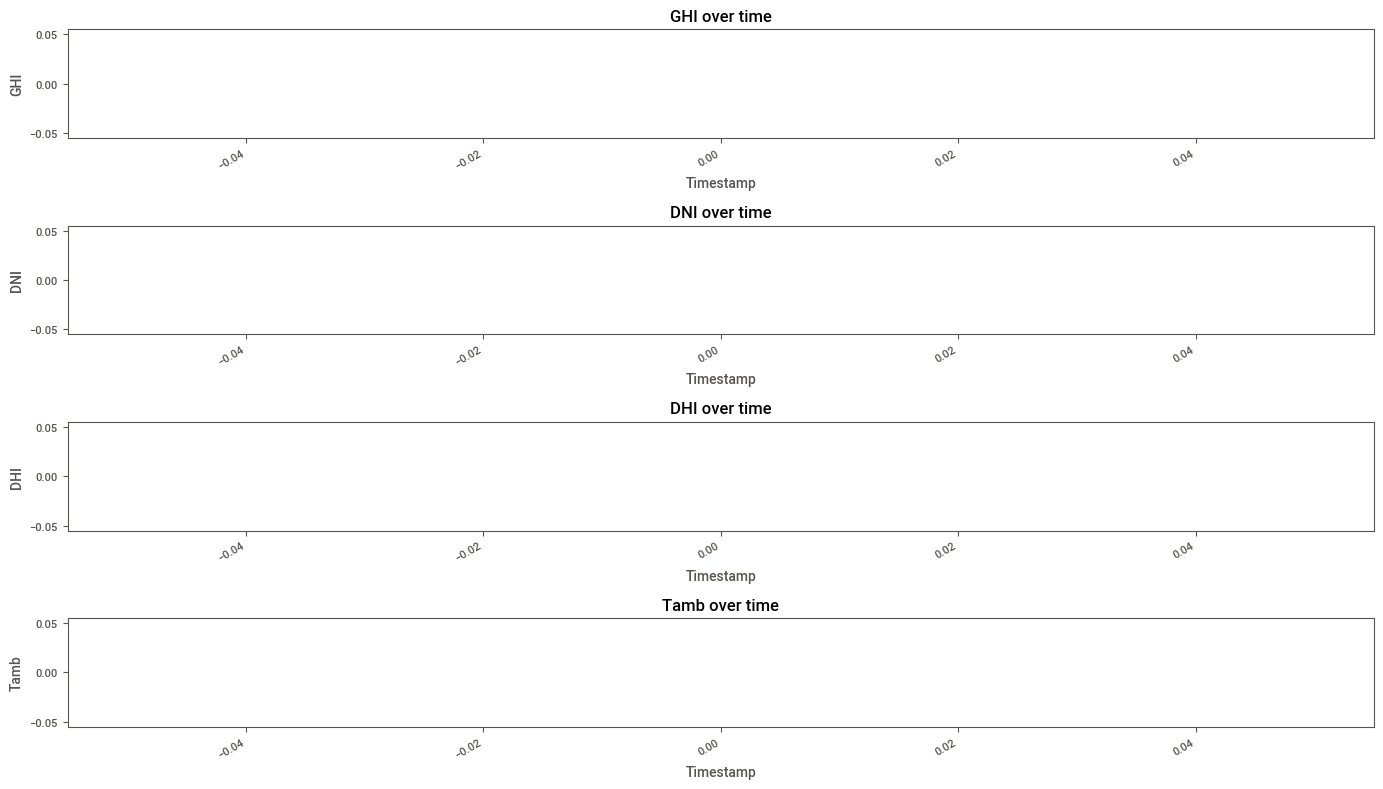

In [72]:
from matplotlib import pyplot as plt


plt.figure(figsize=(14,8))
cols = ['GHI','DNI','DHI','Tamb']
for i, c in enumerate(cols, 1):
    plt.subplot(len(cols),1,i)
    if c in ts.columns:
        ts[c].plot(linewidth=0.6)
        plt.ylabel(c)
        plt.title(f'{c} over time')
    else:
        plt.text(0.2, 0.5, f'{c} not found', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()


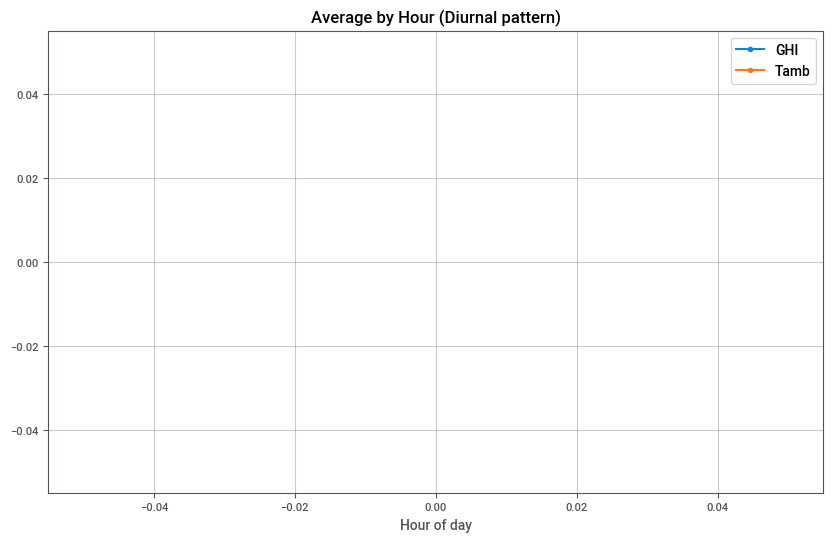

In [73]:
# average value for each hour of day — good to see diurnal pattern
hourly = ts.groupby('hour')[['GHI','DNI','DHI','Tamb']].mean()
plt.figure(figsize=(10,6))
if 'GHI' in hourly.columns:
    hourly['GHI'].plot(label='GHI', marker='o')
if 'Tamb' in hourly.columns:
    hourly['Tamb'].plot(label='Tamb', marker='o')
plt.xlabel('Hour of day')
plt.title('Average by Hour (Diurnal pattern)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [ ]:
monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()
# Diagnostics: show shape and non-null counts to avoid plotting empty data
print('monthly.shape =', monthly.shape)
if 'GHI' in monthly.columns:
    print('GHI non-null count (monthly):', monthly['GHI'].notna().sum())
plt.figure(figsize=(10,5))
# Only attempt to plot if there is at least one non-NaN value
if 'GHI' in monthly.columns and monthly['GHI'].dropna().size > 0:
    ax = monthly['GHI'].plot(marker='o')
    ax.set_title('Monthly average GHI')
    ax.set_ylabel('GHI (W/m²)')
    plt.show()
else:
    print('No monthly GHI data to plot (empty or all NaN). Check `ts` and `Timestamp` parsing/indexing.')


monthly.shape = (0, 4)
GHI non-null count (monthly): 0
No monthly GHI data to plot (empty or all NaN). Check `ts` and `Timestamp` parsing/indexing.


C:\Users\user\AppData\Local\Temp\ipykernel_26180\2904297991.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()


<Figure size 1000x500 with 0 Axes>

In [76]:
print(ts.index.dtype)
print(ts.head())


datetime64[ns]
Empty DataFrame
Columns: [GHI, DNI, DHI, ModA, ModB, Tamb, RH, WS, WSgust, WSstdev, WD, WDstdev, BP, Cleaning, Precipitation, TModA, TModB, Comments, _outlier_flag, year, month, hour, date, day]
Index: []

[0 rows x 24 columns]


In [81]:
df_new = df.drop('Comments', axis=1)

In [82]:
print(ts.columns)
print(ts['GHI'].describe())


Index(['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust',
       'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA',
       'TModB', 'Comments', '_outlier_flag', 'year', 'month', 'hour', 'date',
       'day'],
      dtype='object')
count    0.0
mean     NaN
        ... 
75%      NaN
max      NaN
Name: GHI, Length: 8, dtype: float64


In [83]:
monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()
print(monthly.head())


Empty DataFrame
Columns: [GHI, DNI, DHI, Tamb]
Index: []


C:\Users\user\AppData\Local\Temp\ipykernel_26180\3801729641.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()


In [92]:
from scipy import stats

# compute rolling mean and std for GHI and flag large deviations
if 'GHI' in ts.columns:
    # Diagnostics: counts and basic stats
    non_null = ts['GHI'].notna().sum()
    total = len(ts)
    print(f'GHI non-null / total = {non_null} / {total}')
    if non_null == 0:
        print('All GHI values are NaN — check earlier imputation or source data. Skipping anomaly plot.')
    else:
        print('GHI stats:', ts['GHI'].min(), ts['GHI'].quantile(0.25), ts['GHI'].median(), ts['GHI'].mean(), ts['GHI'].max())
        roll_mean = ts['GHI'].rolling(window=24, min_periods=6).mean()
        roll_std  = ts['GHI'].rolling(window=24, min_periods=6).std().replace(0, np.nan)
        rolling_z = (ts['GHI'] - roll_mean) / roll_std
        anomalies = rolling_z.abs() > 4   # threshold, tune as needed
        print('Anomalies detected (count):', int(anomalies.sum()))

        plt.figure(figsize=(14,4))
        # Explicit color and marker to ensure visibility
        ax = ts['GHI'].plot(alpha=0.9, label='GHI', color='tab:blue', linewidth=0.8, marker='.', markersize=2)
        if anomalies.any():
            ax.scatter(ts.index[anomalies], ts['GHI'][anomalies], color='red', s=20, label='Anomaly')
        ax.set_title('GHI with rolling-z anomalies')
        ax.set_ylabel('GHI')
        ax.legend()
        # If data range is extremely small, give a small padding so points are visible
        try:
            ymin, ymax = ax.get_ylim()
            if (ymax - ymin) == 0 or (abs(ymax - ymin) < 1e-6):
                pad = max(1e-3, abs(ymax) * 0.1)
                ax.set_ylim(ymin - pad, ymax + pad)
        except Exception:
            pass
        plt.show()


GHI non-null / total = 0 / 0
All GHI values are NaN — check earlier imputation or source data. Skipping anomaly plot.


In [1]:
# diagnostic: see if ts exists and what's in it
try:
    print("ts type:", type(ts))
    print("index name/type:", ts.index.name, type(ts.index))
    print("index dtype:", getattr(ts.index, 'dtype', None))
    print("index monotonic:", getattr(ts.index, 'is_monotonic', None))
    print("ts.head():")
    display(ts.head())
    print("GHI non-null count:", ts['GHI'].notna().sum() if 'GHI' in ts.columns else "no GHI column")
    print("GHI dtype:", ts['GHI'].dtype if 'GHI' in ts.columns else None)
except NameError:
    print("No variable named ts in the notebook right now.")

No variable named ts in the notebook right now.


In [2]:
import pandas as pd
fn = "data/benin_clean.csv"
df = pd.read_csv(fn, parse_dates=['Timestamp'], infer_datetime_format=True)
# ensure GHI numeric
df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
# set index and sort
df = df.set_index('Timestamp').sort_index()
# drop any tz if present
df.index = pd.to_datetime(df.index).tz_localize(None)
print("df.shape:", df.shape)
print("GHI non-null count:", df['GHI'].notna().sum())
ts = df  # recreate ts used in the notebook

C:\Users\user\AppData\Local\Temp\ipykernel_13340\3778844811.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(fn, parse_dates=['Timestamp'], infer_datetime_format=True)


df.shape: (525600, 22)
GHI non-null count: 525600


C:\Users\user\AppData\Local\Temp\ipykernel_13340\2736684334.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()


monthly.shape: (13, 4)
monthly['GHI'] non-NA count: 13


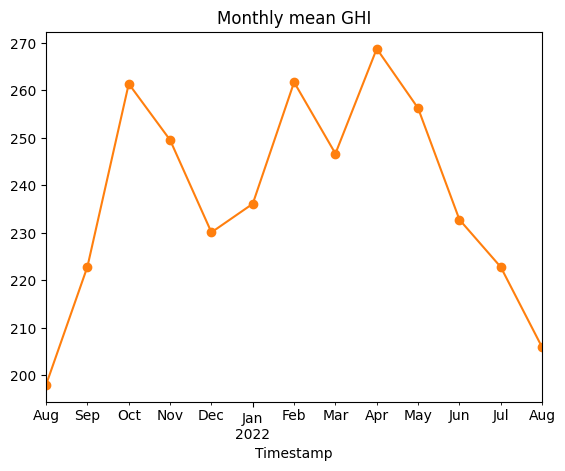

In [3]:
monthly = ts.resample('M')[['GHI','DNI','DHI','Tamb']].mean()
print("monthly.shape:", monthly.shape)
print("monthly['GHI'] non-NA count:", monthly['GHI'].dropna().size if 'GHI' in monthly.columns else "no GHI")
if 'GHI' in monthly.columns and monthly['GHI'].dropna().size > 0:
    ax = monthly['GHI'].plot(title="Monthly mean GHI", color='tab:orange', marker='o')
    y = monthly['GHI'].dropna()
    # pad y-limits slightly so a flat line is visible
    yr = y.max() - y.min()
    if yr == 0:
        ax.set_ylim(y.iloc[0] - 1, y.iloc[0] + 1)
    else:
        ax.set_ylim(y.min() - 0.05*yr, y.max() + 0.05*yr)
else:
    print("No monthly GHI data to plot (empty or all NaN).")

GHI series length: 525600
GHI stats: count    525600.000000
mean        240.559452
std         331.131327
min         -12.900000
25%          -2.000000
50%           1.800000
75%         483.400000
max        1413.000000
Name: GHI, dtype: float64
anomaly count: 803
anomaly count: 803


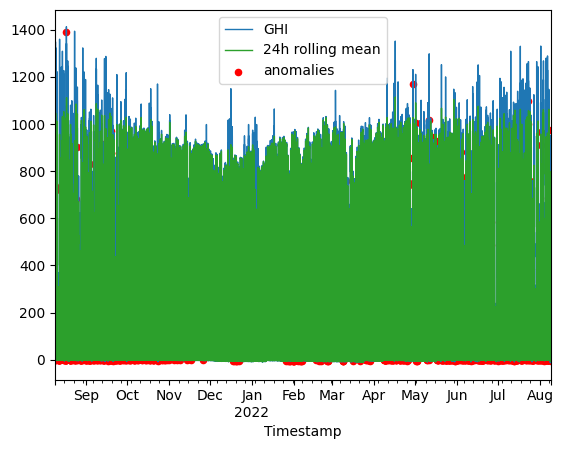

In [4]:
s = ts['GHI'].dropna()
print("GHI series length:", len(s))
print("GHI stats:", s.describe())
roll_mean = s.rolling(window=24, min_periods=6).mean()
roll_std  = s.rolling(window=24, min_periods=6).std().replace(0, pd.NA)
rolling_z = (s - roll_mean) / roll_std
anoms = rolling_z.abs() > 4
print("anomaly count:", anoms.sum())
ax = s.plot(color='tab:blue', lw=1, label='GHI')
ax = roll_mean.plot(ax=ax, color='tab:green', lw=1, label='24h rolling mean')
ax.scatter(s.index[anoms], s[anoms], color='red', s=20, label='anomalies')
ax.legend()

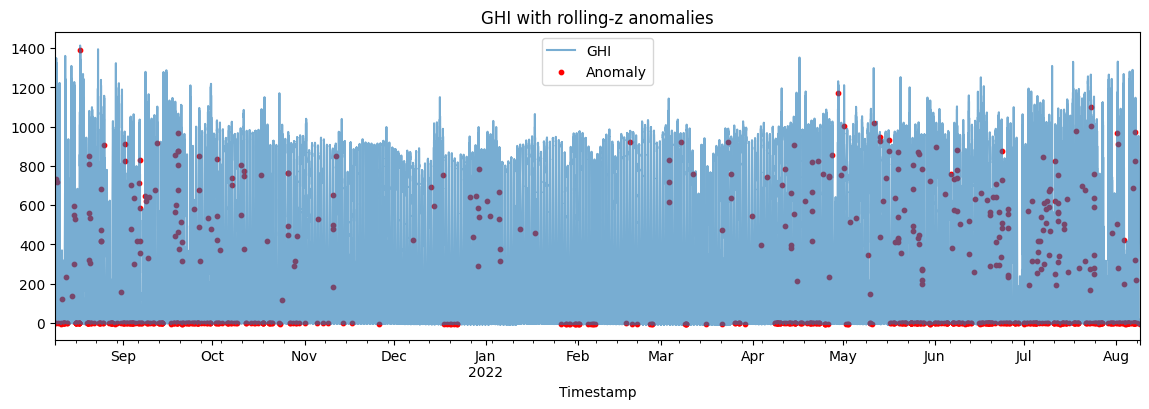

In [10]:
import numpy as np
from matplotlib import pyplot as plt

# compute rolling mean and std for GHI and flag large deviations
# (re-uses existing imports and variables in the notebook: np, plt, ts)
if 'GHI' in ts.columns:
    roll_mean = ts['GHI'].rolling(window=24, min_periods=6).mean()
    roll_std = ts['GHI'].rolling(window=24, min_periods=6).std().replace(0, np.nan)
    rolling_z = (ts['GHI'] - roll_mean) / roll_std
    anomalies = rolling_z.abs() > 4   # threshold, tune as needed

    plt.figure(figsize=(14,4))
    ax = ts['GHI'].plot(alpha=0.6, label='GHI')
    if anomalies.any():
        ax.scatter(ts.index[anomalies], ts['GHI'][anomalies], color='red', s=10, label='Anomaly')
    ax.set_title('GHI with rolling-z anomalies')
    ax.legend()
    plt.show()
else:
    print("Column 'GHI' not found in ts.")


                ModA        ModB
Cleaning                        
0         236.524253  228.816071
1         307.229278  301.972165


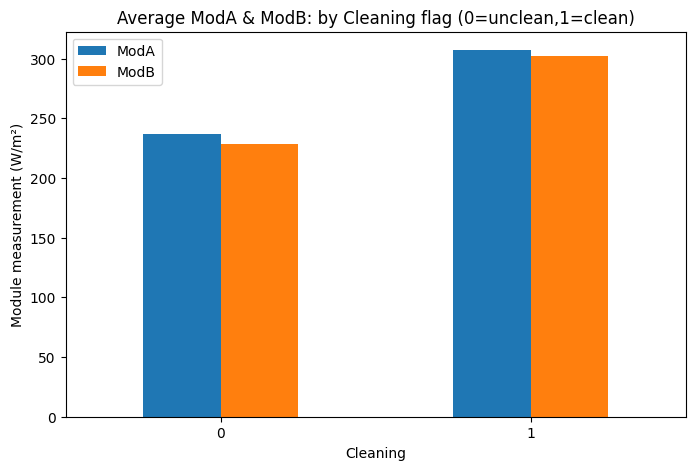

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


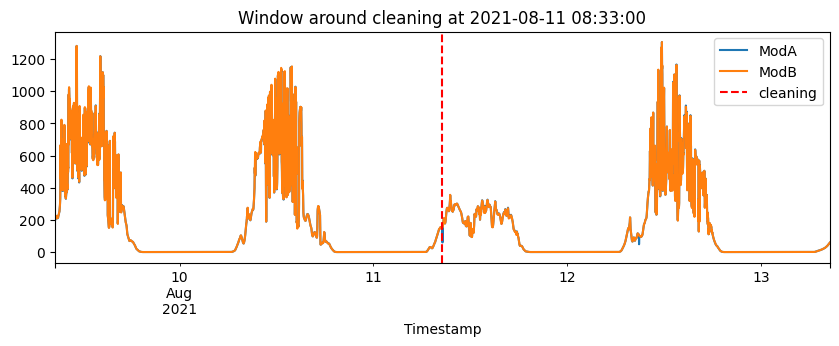

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


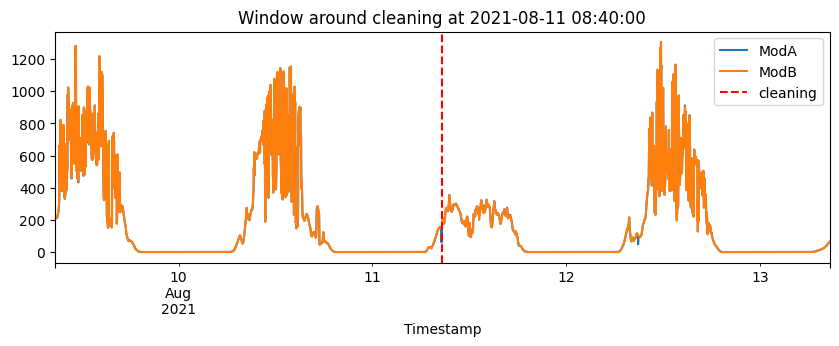

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


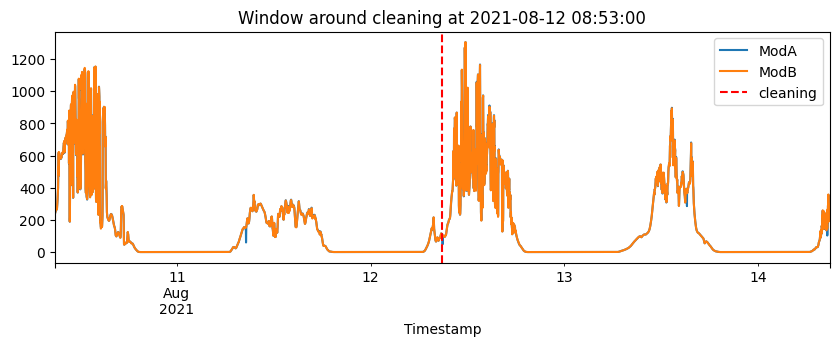

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


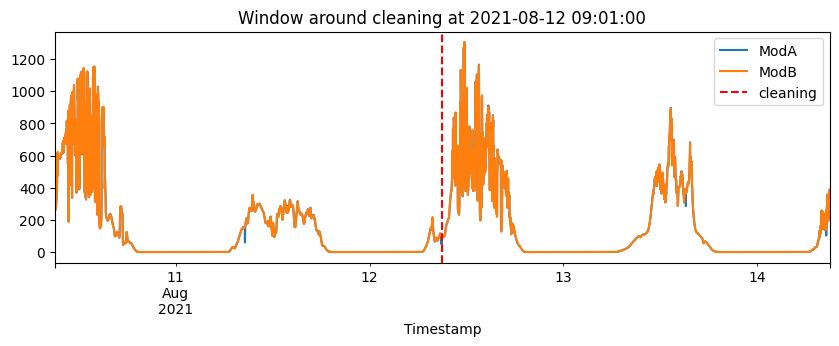

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


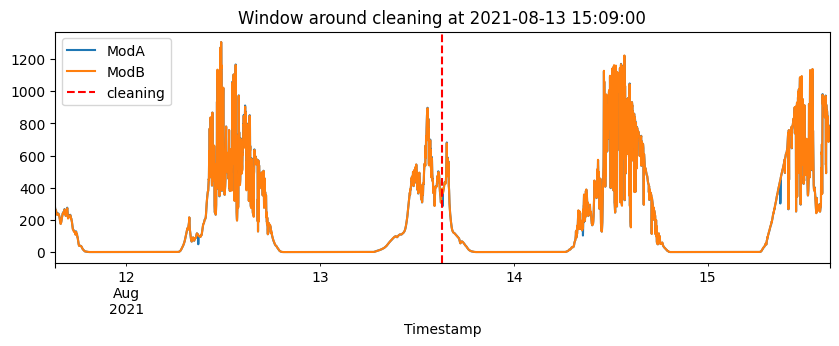

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


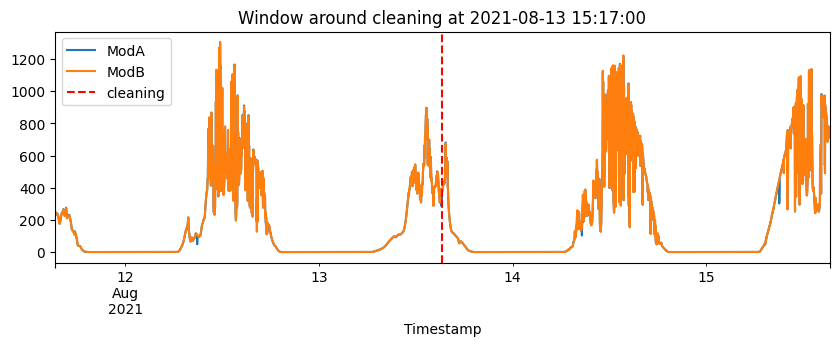

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


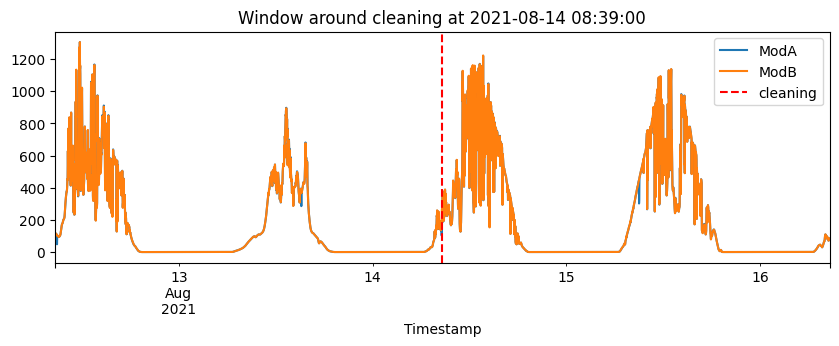

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


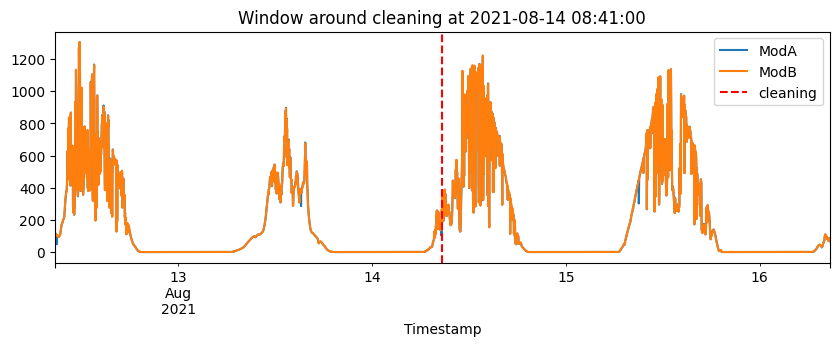

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


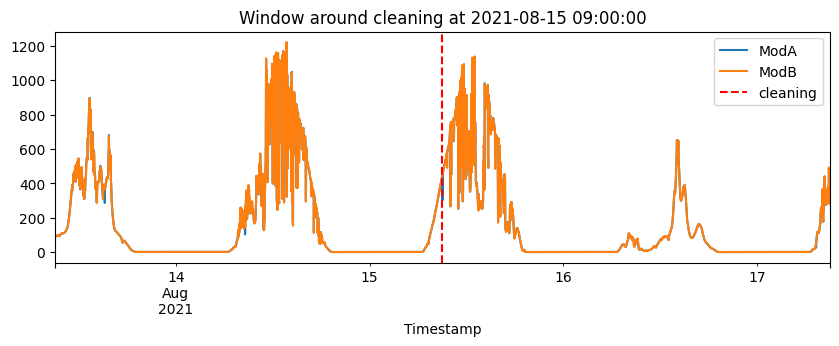

C:\Users\user\AppData\Local\Temp\ipykernel_13340\157551485.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]


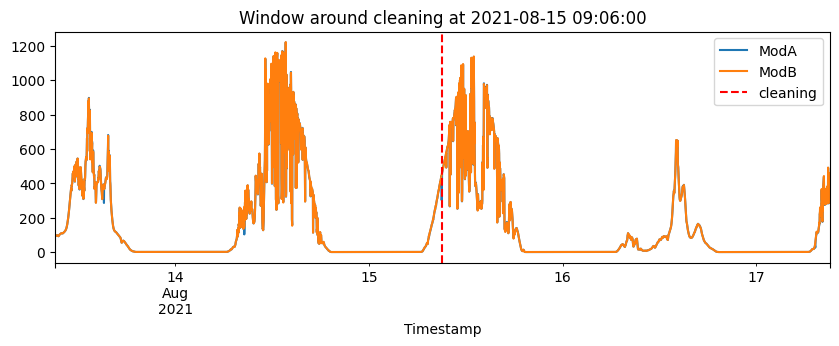

In [12]:
# Use `ts` (time-series DataFrame) which is available in the notebook instead of `clean`
if 'Cleaning' in ts.columns:
    # compute averages grouped by Cleaning flag
    cols = [c for c in ['ModA', 'ModB'] if c in ts.columns]
    if cols:
        grp = ts.groupby('Cleaning')[cols].mean()
        print(grp)

        # bar plot
        grp.plot(kind='bar', figsize=(8,5))
        plt.title('Average ModA & ModB: by Cleaning flag (0=unclean,1=clean)')
        plt.ylabel('Module measurement (W/m²)')
        plt.xticks(rotation=0)
        plt.show()
    else:
        print("No ModA/ModB columns found in `ts` to plot.")

    # time series of averages around cleaning events:
    # if cleaning events are sparse, look window +/- 48 hours around events
    cleaning_times = ts[ts['Cleaning']==1].index
    # sample up to first 10 cleaning events to inspect
    for t in cleaning_times[:10]:
        window = ts.loc[t - pd.Timedelta('48H') : t + pd.Timedelta('48H')]
        plt.figure(figsize=(10,3))
        if 'ModA' in window.columns:
            window['ModA'].plot(label='ModA')
        if 'ModB' in window.columns:
            window['ModB'].plot(label='ModB')
        plt.axvline(t, color='red', linestyle='--', label='cleaning')
        plt.title(f'Window around cleaning at {t}')
        plt.legend()
        plt.show()
else:
    print("`Cleaning` column not found in `ts`.")


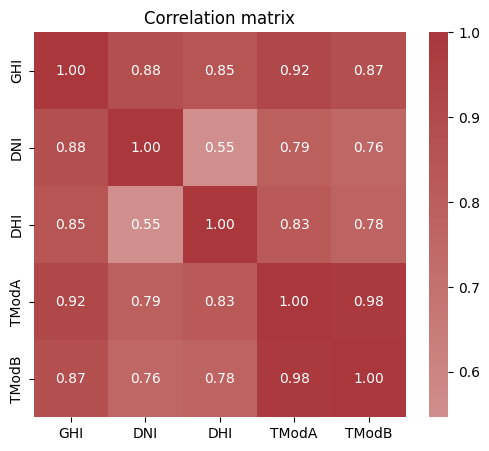

In [15]:
import seaborn as sns
vars_corr = [c for c in ['GHI','DNI','DHI','TModA','TModB'] if c in ts.columns]
corr = ts[vars_corr].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix')
plt.show()


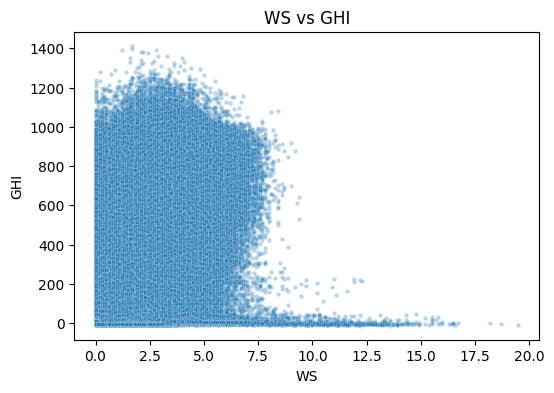

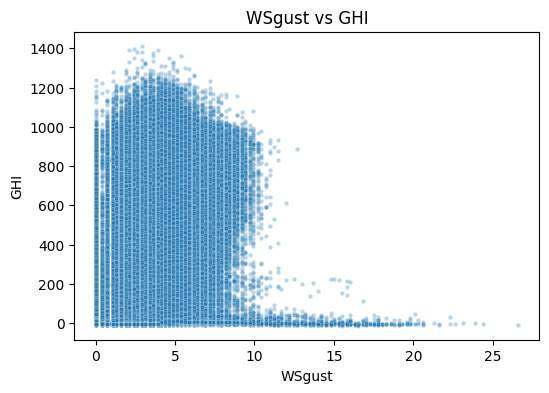

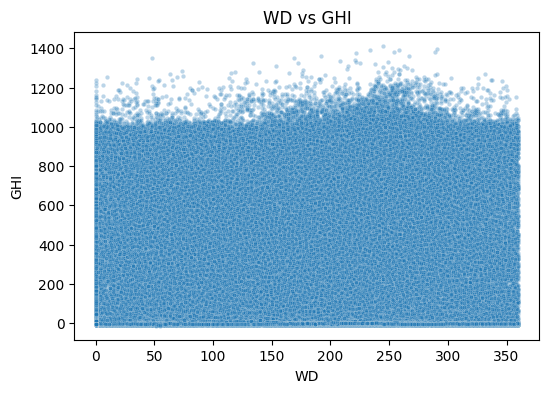

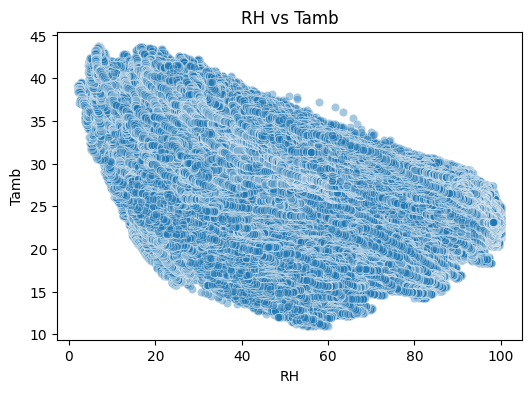

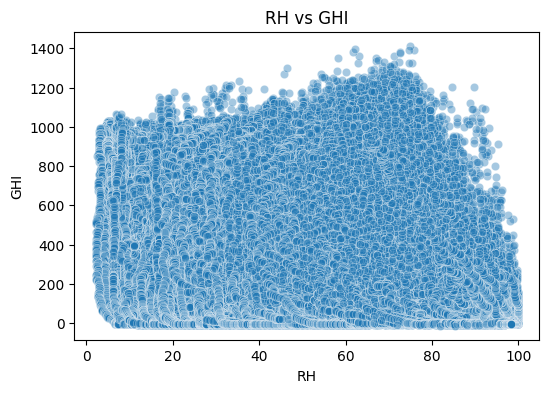

In [16]:
# WS and WSgust vs GHI
for wind_col in ['WS','WSgust','WD']:
    if wind_col in ts.columns and 'GHI' in ts.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=ts[wind_col], y=ts['GHI'], alpha=0.3, s=10)
        plt.title(f'{wind_col} vs GHI')
        plt.show()

# RH vs Tamb and RH vs GHI
if 'RH' in ts.columns:
    if 'Tamb' in ts.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=ts['RH'], y=ts['Tamb'], alpha=0.4)
        plt.title('RH vs Tamb')
        plt.show()
    if 'GHI' in ts.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=ts['RH'], y=ts['GHI'], alpha=0.4)
        plt.title('RH vs GHI')
        plt.show()


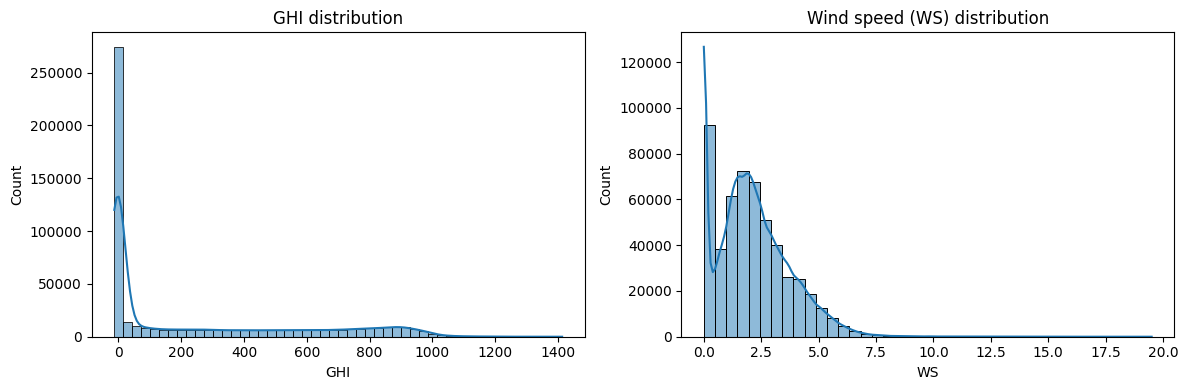

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
if 'GHI' in ts.columns:
    sns.histplot(ts['GHI'].dropna(), bins=50, kde=True)
    plt.title('GHI distribution')

plt.subplot(1,2,2)
if 'WS' in ts.columns:
    sns.histplot(ts['WS'].dropna(), bins=40, kde=True)
    plt.title('Wind speed (WS) distribution')
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_13340\3301396495.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rose = ts.groupby('wd_bin')['WS'].mean().reset_index()


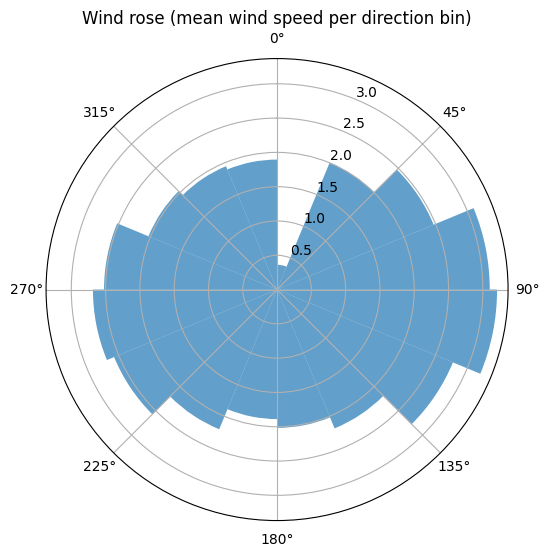

In [18]:
if all(c in ts.columns for c in ['WD','WS']):
    # bin directions into 16 sectors
    n_bins = 16
    bins = np.linspace(0, 360, n_bins+1)
    ts['wd_bin'] = pd.cut(ts['WD'] % 360, bins=bins, include_lowest=True, right=False)
    # compute mean wind speed per bin
    rose = ts.groupby('wd_bin')['WS'].mean().reset_index()
    # center angle for each bin
    rose['angle'] = (bins[:-1] + (bins[1]-bins[0])/2) * np.pi/180

    # convert to arrays
    angles = rose['angle'].values
    values = rose['WS'].values
    width = 2*np.pi / n_bins

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, polar=True)
    bars = ax.bar(angles, values, width=width, bottom=0.0, alpha=0.7)
    ax.set_theta_zero_location('N')   # 0 at North
    ax.set_theta_direction(-1)        # clockwise
    ax.set_title('Wind rose (mean wind speed per direction bin)')
    plt.show()


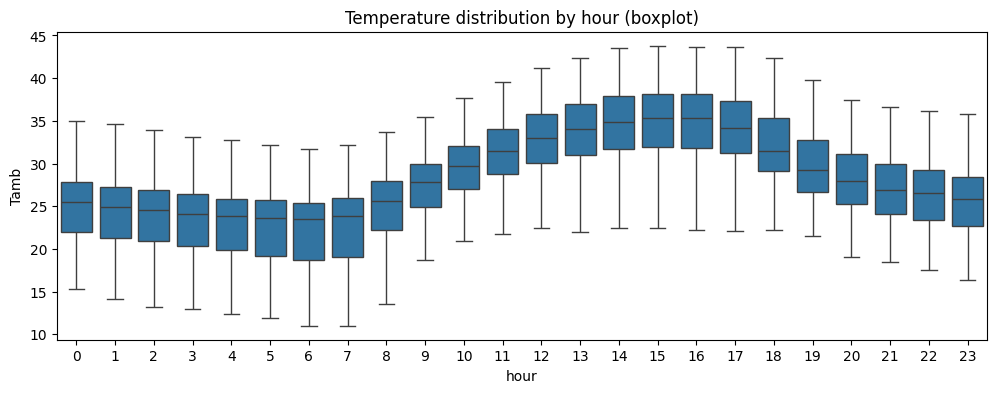

In [19]:
if 'RH' in ts.columns and 'Tamb' in ts.columns:
    plt.figure(figsize=(12,4))
    sns.boxplot(x='hour', y='Tamb', data=ts.reset_index(), showfliers=False)
    plt.title('Temperature distribution by hour (boxplot)')
    plt.show()


Pearson corr (RH, Tamb): -0.4148417749799551


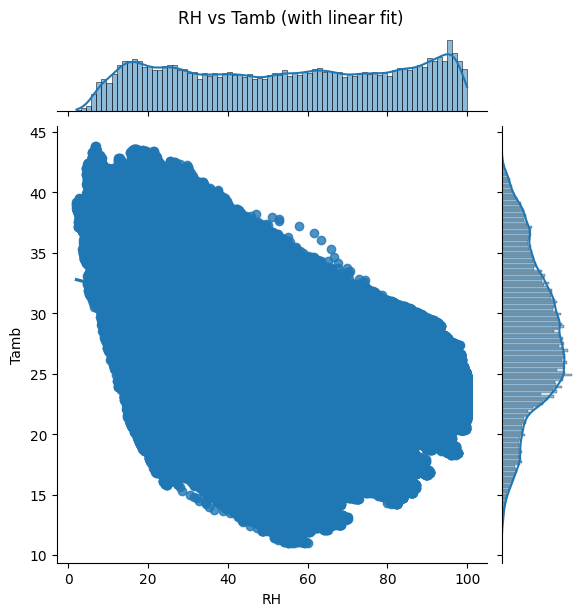

In [20]:
if 'RH' in ts.columns and 'Tamb' in ts.columns:
    corr_rt = ts['RH'].corr(ts['Tamb'])
    print("Pearson corr (RH, Tamb):", corr_rt)

    sns.jointplot(x=ts['RH'], y=ts['Tamb'], kind='reg', height=6)
    plt.suptitle('RH vs Tamb (with linear fit)', y=1.02)
    plt.show()


Pearson corr (RH, GHI): -0.3600286885499285


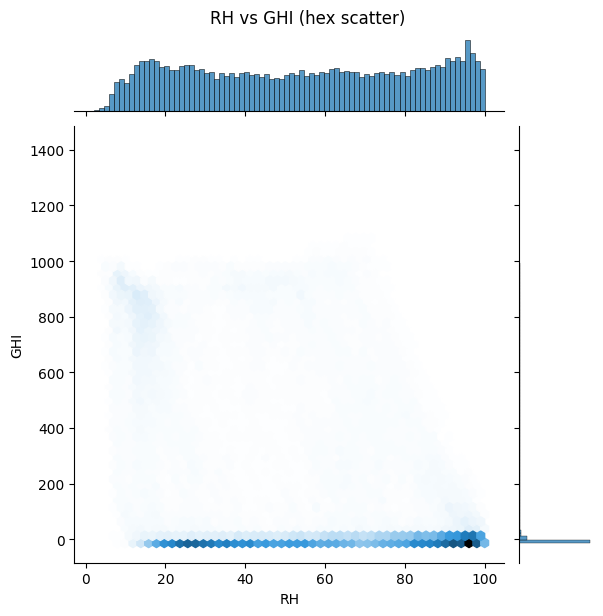

In [21]:
if 'RH' in ts.columns and 'GHI' in ts.columns:
    print("Pearson corr (RH, GHI):", ts['RH'].corr(ts['GHI']))
    sns.jointplot(x=ts['RH'], y=ts['GHI'], kind='hex', height=6)
    plt.suptitle('RH vs GHI (hex scatter)', y=1.02)
    plt.show()


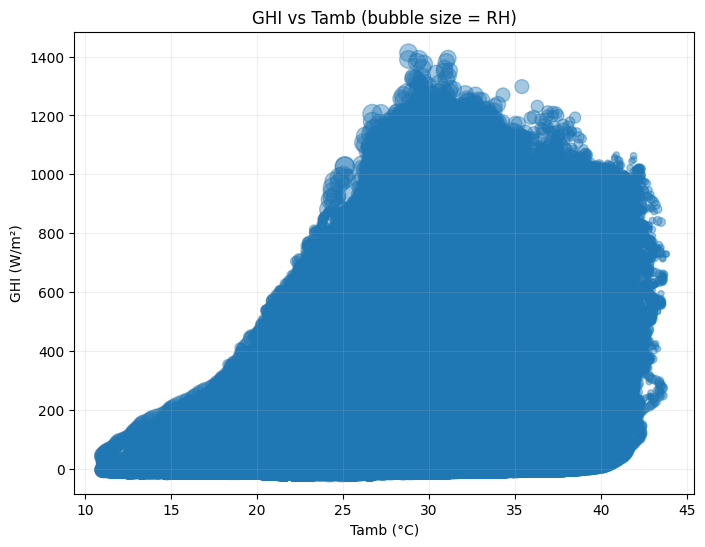

In [22]:
plt.figure(figsize=(8,6))
if 'GHI' in ts.columns and 'Tamb' in ts.columns:
    size_col = 'RH' if 'RH' in ts.columns else 'BP' if 'BP' in ts.columns else None
    sizes = (ts[size_col].fillna(ts[size_col].median()) if size_col else pd.Series(1, index=ts.index))
    # scale sizes for visibility
    sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9) * 200 + 10

    plt.scatter(ts['Tamb'], ts['GHI'], s=sizes, alpha=0.4)
    plt.xlabel('Tamb (°C)')
    plt.ylabel('GHI (W/m²)')
    plt.title('GHI vs Tamb (bubble size = {})'.format(size_col))
    plt.grid(alpha=0.2)
    plt.show()
